# K-Means glyphs (Drawbot Ver.)

By [Allison Parrish](http://www.decontextualize.com)

(Translated to Drawbot code by Lynne Yun)

It's sometimes desirable to generate a set of points that are randomly positioned, but that nevertheless have some space between them. An easy way to do this is to generate a lot of random points, and then cluster those points into a number of groups using a clustering algorithm. The midpoints ("centroid") of each cluster will form a set of points that are randomly positioned, but that still have space between them.

In this notebook, I show how to use K-Means clustering on randomly generated points in order to create asemic glyphs. I use [Bezmerizing](https://github.com/aparrish/bezmerizing/) to represent the data and [Flat](https://xxyxyz.org/flat) to draw it.

I am indebted to Anders Hoff's blog post about [Spline Script](https://inconvergent.net/2017/spline-script/), whose general details inspired this implementation.

## The problem with random points

To illustrate the problem, let's draw some random points using Flat.

In [102]:
import numpy as np
from flat import document, shape, rgb, rgba
from bezmerizing import Polyline
import random
import drawBot as draw
import os

In [103]:
from IPython.display import Image, display
                
def show(png):
    drawing = Image(filename = "drawBotImage.png")
    display(drawing)

The following cell uses numpy's `uniform` function to generate an array of ten random 2d points:

In [104]:
pts = np.random.uniform(size=(10, 2))

We'll draw these points and the polyline that connects them, scaled up a bit:

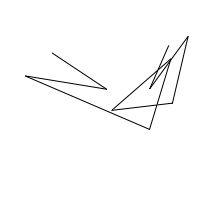

In [105]:
draw.newDrawing()
draw.newPage(200, 200)

pline = Polyline(pts)
lines = pline.scale(190)
draw.stroke(0,0,0,1)
draw.fill(0,0,0,0)

draw.newPath()
draw.moveTo(lines.vertices[0])
for item in lines.vertices[1:]:
    draw.lineTo(item)
    
draw.drawPath()

draw.saveImage("drawBotImage.png")
draw.endDrawing()
show(Image)

A potential problem with this technique for the purpose of creating asemic glyphs is that it can produce points that are "bunched up" in particular areas. I've observed that in most writing systems, important graphical features of characters tend to be spread out a bit, not bunched together. In [previous notebooks](lines-and-asemic.ipynb), we've solved this problem by forcing the points to be selected on a grid. This works, but it ends up producing glyphs that have boxy, predictable forms. Maybe there are better (or at least different) ways to do this!

## K-Means clustering

[Cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis) is the name for a number of statistical and algorithmic techniques that automatically find groups of common items in a data set. Wikipedia has a good list of [typical uses of cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis#Applications), such as creating biological phylogenies and recommendation algorithms.

We're going to use one particular clustering algorithm, [K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means), in a sort of "off-label" way. The K-Means algorithm iteratively splits the plane up into sections, in order to produce a list of maximally distinctive points that form the center of a certain number of clusters. If we use this algorithm to cluster random data, we'll end up with a list of points that are randomly placed but also maximally distant from each other.

To demonstrate, the following cell generates a few hundred points from a uniform distribution, from 0 to 50:

In [106]:
pts = np.random.uniform(low=0, high=200, size=(400, 2))

Plotting these on the canvas:

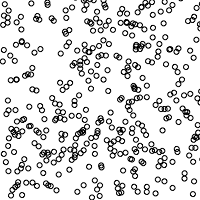

In [231]:
draw.newDrawing()
draw.newPage(200, 200)

draw.stroke(0,0,0,1)
draw.fill(0,0,0,0)

for item in pts:
    draw.oval(item[0],item[1], 5,5)
    
draw.saveImage("drawBotImage.png")
draw.endDrawing()
show(Image)

To cluster these points, we'll use [scikit-learn](https://scikit-learn.org/stable/)'s [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) class: 

In [109]:
from sklearn.cluster import MiniBatchKMeans

Clustering the data is a matter of creating a `MiniBatchKMeans` object, using its `.fit()` method to fit the model to the points, then accessing the `cluster_centers_` attribute of the object to get the cluster centers. You get to pick the number of clusters that K-Means should look for—pass it to the constructor function as the `n_clusters` parameter.

In [142]:
km = MiniBatchKMeans(n_clusters=5)
km.fit(pts)
km.cluster_centers_

array([[ 47.2874665 ,  52.59334543],
       [163.84507069,  90.8828269 ],
       [129.42148067, 164.59213035],
       [ 44.94450377, 145.91886698],
       [138.06427538,  34.65167686]])

The following cell shows the original points plus the cluster centers calculated by K-Means:

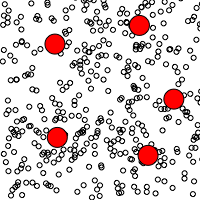

In [143]:
draw.newDrawing()
draw.newPage(200, 200)

draw.stroke(0,0,0,1)
draw.fill(0,0,0,0)

for item in pts:
    draw.oval(item[0],item[1], 5,5)
    
draw.stroke(0,0,0,1)
draw.fill(1,0,0,1)

for item in km.cluster_centers_:
    draw.oval(item[0],item[1], 20,20)
    
draw.saveImage("drawBotImage.png")
draw.endDrawing()
show(Image)

As you can see, the five cluster center points are random, but are still spread out across the canvas.

To demonstrate how the algorithm works a bit more, the code in the following cell draws each point in a color corresponding to the cluster it belongs to. You can see that K-Means divides the canvas up into five roughly equal sections:

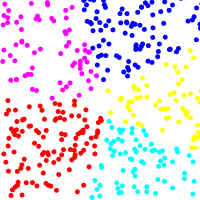

In [197]:
draw.newDrawing()
draw.newPage(200,200)
cluster_brushes = [
    (1,0,0,1),
    (1,1,0,1),
    (0,0,1,1),
    (1,0,1,1),
    (0,1,1,1)
]

labels = km.predict(pts)

for i in range(len(pts)):
    draw.fill(*(cluster_brushes[labels[i]]))
    draw.oval(pts[i][0], pts[i][1], 5,5)
    
draw.saveImage("drawBotImage.png")
draw.endDrawing()
show(Image)

## K-Means glyphs

So now let's generate some weird asemic glyphs! The `kmeans_glyph` function, defined below, returns a `Polyline` object made from the cluster centroids of a K-Means clusterer fit on a bunch of randomly generated points. You can specify the number of clusters with the `n_clusters` parameter:

In [198]:
def kmeans_glyph(n_clusters=6):
    data = np.random.uniform(low=-0.5, high=0.5, size=(500, 2))
    km = MiniBatchKMeans(n_clusters=n_clusters, max_iter=25)
    km.fit(data)
    np.random.shuffle(km.cluster_centers_)
    return Polyline(km.cluster_centers_)

(The function also shuffles the cluster centers to add a bit of variety.)

The code in the cell below draws the glyph as a polyline and as a Catmull-Rom spline, with points drawn as small white circles:

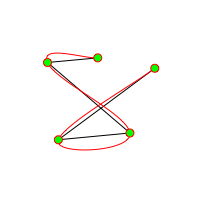

In [234]:
draw.newDrawing()
draw.newPage(200,200)
glyph = kmeans_glyph(random.randrange(5, 8)).scale(150).translate(100, 100)
glyph_curved = glyph.augment().smooth_path(tightness=-0.5)


#draw Polyline
polyline = draw.BezierPath()
polyline.moveTo(glyph.vertices[0])
for item in glyph.vertices[1:]:
    polyline.lineTo(item)
    
draw.fill(0,0,0,0)
draw.stroke(0,0,0,1)
draw.drawPath(polyline)

#draw Curved Line
curved_line = draw.BezierPath()
for cmd in glyph_curved.commands:
    if 'moveto' in str(type(cmd)):
        curved_line.moveTo((cmd.x, cmd.y))
    elif 'curveto' in str(type(cmd)):
        curved_line.curveTo((cmd.x1, cmd.y1), (cmd.x2, cmd.y2), (cmd.x, cmd.y))

        draw.stroke(1,0,0,1)
draw.drawPath(curved_line)

#draw circles
draw.fill(0,1,0,1)
for item in glyph.vertices:
    draw.oval(item[0]-4,item[1]-4,8,8)


draw.saveImage("drawBotImage.png")
draw.endDrawing()
show(Image)

The more evenly-spaced points, I think, give the glyph a slightly more structured and "natural" feel. Let's draw a bunch of these on a grid:

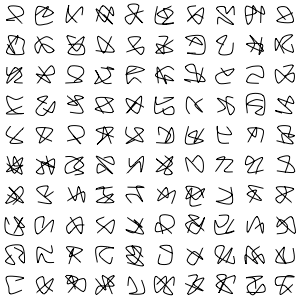

In [238]:
width = 300
height = 300
draw.newDrawing()
draw.newPage(canvas,canvas)

draw.fill(0,0,0,0)
draw.stroke(0,0,0,1)

grid_size = 10 # change the number of elements in the grid on one side
cell_size_x = width/grid_size
cell_size_y = height/grid_size
for i in range(grid_size):
    for j in range(grid_size):
        scale_val = (width / grid_size) * 0.8
        x = i * cell_size_x + (cell_size_x * 0.5)
        y = j * cell_size_y + (cell_size_y * 0.5)
        glyph = kmeans_glyph(random.randrange(6, 10)).scale(scale_val).translate(x, y)
        glyph_curved = glyph.augment().smooth_path()
        path = draw.BezierPath()
        for cmd in glyph_curved.commands:
            if 'moveto' in str(type(cmd)):
                path.moveTo((cmd.x, cmd.y))
            elif 'curveto' in str(type(cmd)):
                path.curveTo((cmd.x1, cmd.y1), (cmd.x2, cmd.y2), (cmd.x, cmd.y))
        draw.drawPath(path)
        
draw.saveImage("drawBotImage.png")
draw.endDrawing()
show(Image)

A slightly more sophisticated example, using Bezmerizing's `.fancy_curve()` to extrude a polygon along the smooth curve path, and adding an affine shear transformation to make the characters seem a bit italic:

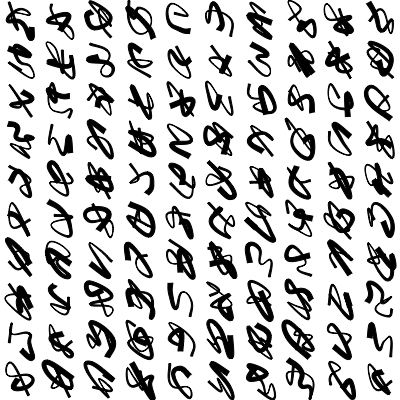

In [242]:
width = 400
height = 400
draw.newDrawing()
draw.newPage(width,height)

draw.fill(0,0,0,1)
draw.stroke(0,0,0,1)

grid_size = 10 # change the number of elements in the grid on one side
cell_size_x = width/grid_size
cell_size_y = height/grid_size
for i in range(grid_size):
    for j in range(grid_size):
        scale_val = (width / grid_size) * 0.8
        x = i * cell_size_x + (cell_size_x * 0.5)
        y = j * cell_size_y + (cell_size_y * 0.5)
        
        glyph = kmeans_glyph(random.randrange(6, 10))
        # affine shear transformation
        glyph.vertices = glyph.vertices.dot(
            np.array([[1, -0.67],  
                      [0, 1]]))
        glyph = glyph.scale(scale_val).translate(x, y)
        glyph_curve = glyph.augment().fancy_curve(samples_per=12,
                                                  thicknesses=[5, 3, 0.25, 2],
                                                  tightness=-0.5)        
        fancy_path = draw.BezierPath()
        fancy_path.moveTo(glyph_curve.vertices[0])
        for item in glyph_curve.vertices[1:]:
            fancy_path.lineTo(item)
        draw.drawPath(fancy_path)
        
draw.saveImage("drawBotImage.png")
draw.endDrawing()
show(Image)